In [1]:
import pandas as pd
import numpy as np
import math

# stats
import seaborn as sns
import scipy
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [4]:
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

In [5]:
def plot_likelihood(p_vec, f_p):    
    plt.figure(figsize=(4,3))
    plt.plot(p_vec, f_p)
    plt.title("Likelihood of rain on this day given n_rain_obs on this day in past N years", fontsize=8)
    plt.xlabel('p_rain')
    plt.ylabel('likelihood function, f(p_rain)')
    return plt.show()

# Univariate MLE with Discrete Feature
Uses only precipitation data, and only as a binary variable (rained or didn't)

Represents the likelihood function as a binomial distribution (given the discrete binary variable, rain or no rain)

In [16]:
# Sample data - precip values for a hypothetical day of the year
df_this_day = pd.DataFrame({"PRECIP": [0.1, 0.0, 0.2, 0.0, 0.0]})

# Count number of days where PRECIP > 0.0
df_this_day['PRECIP_TRUE'] = df_this_day["PRECIP"].apply(lambda x: 1 if x > 0.0 else 0)

df_this_day.head()

,PRECIP,PRECIP_TRUE
0,0.1,1
1,0.0,0
2,0.2,1
3,0.0,0
4,0.0,0


probability of rain on this day: 0.4
which, is the same as n_rain_obs/n_obs: 0.4

likelihood for p_rain = 0.4: 0.3456


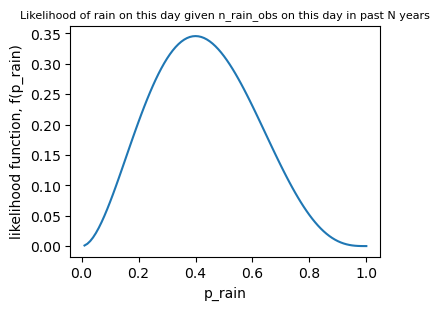

In [11]:
# L(theta | PRECIP_TRUE)

n_obs = len(df_this_day) 
n_rain_obs = df_this_day['PRECIP_TRUE'].sum()

p_vec = np.linspace(0.01, 1, 100)
binomial_coeff = factorial(n_obs) / (factorial(n_rain_obs) * factorial(n_obs-n_rain_obs)) # bc order of rain, no rain etc. doesn't matter
f_p = [binomial_coeff * p**n_rain_obs * (1-p)**(n_obs-n_rain_obs) for p in p_vec] 

max_index = np.argmax(f_p)
p_rain = p_vec[max_index]

print(f"probability of rain on this day:", round(p_rain, 1))
print(f"which, is the same as n_rain_obs/n_obs:", n_rain_obs/n_obs)
print(f"\nlikelihood for p_rain = {p_rain}:", f_p[max_index])

plot_likelihood(p_vec, f_p)

# Multivariate MLE with Continuous Features

Uses continuous precipitation and temperature data

In [15]:
# Data from NOAA for Boston, Miami and Juneau

df = pd.read_csv("noaa_historical_weather_10yr.csv", usecols=['NAME','DATE','PRCP','SNOW','TMAX','TMIN'])

mapping={'MIAMI INTERNATIONAL AIRPORT, FL US': 'mia',
         'JUNEAU AIRPORT, AK US': 'jnu', 
         'BOSTON, MA US': 'bos'}

df.NAME = df.NAME.replace(mapping)

df['PRCP_TOT'] = df["PRCP"] + df["SNOW"]
df['RAIN_TF'] = df["PRCP"].apply(lambda x: 1 if x > 0.0 else 0)
df['SNOW_TF'] = df["SNOW"].apply(lambda x: 1 if x > 0.0 else 0)
df['PRCP_TF'] = df["RAIN_TF"] + df["SNOW_TF"]
df['PRCP_TF'] = df['PRCP_TF'].apply(lambda x: min(x, 1)) # so no 2s

df['DATE'] = pd.to_datetime(df['DATE'])
df['DAY'] = df['DATE'].dt.day
df['DAY_OF_YR'] = df['DATE'].dt.dayofyear
df['MONTH'] = df['DATE'].dt.month
df['YEAR'] = df['DATE'].dt.year

## Logistic Regression

City models

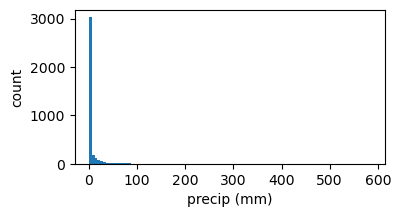

In [19]:
city_name = 'bos'
df_city = df[df.NAME == city_name].copy()

plt.figure(figsize=(4, 2))
plt.hist(df_city.PRCP_TOT, bins=100)
plt.xlabel('precip (mm)')
plt.ylabel('count')
plt.show()

In [20]:
print(f"max rain: {df_city.PRCP.max()} mm, \nmax snow: {df_city.SNOW.max()} mm in {city_name}")

max rain: 86.4 mm, 
max snow: 561.0 mm in bos


Functions for feature engineering

In [21]:
def calc_zscore(df, col):
    df[col + "_Z"] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [22]:
def make_day_cyclical(df):

    df['DAY_RAD'] = 2 * np.pi * df['DAY_OF_YR'] / 365
    df['DAY_SIN'] = np.sin(df['DAY_RAD'])
    df['DAY_COS'] = np.sin(df['DAY_RAD'])

    df = df.drop('DAY_RAD', axis=1)

    return df

Feature engineering

In [181]:

# log transform PRCP because of enormous skew
df_city['PRCP_LN'] = np.log(df_city['PRCP_TOT'] + 10**-3)

# normalize using z-score
df_city = calc_zscore(df_city, 'PRCP_LN')
df_city = calc_zscore(df_city, 'TMAX')
df_city = calc_zscore(df_city, 'TMIN')

# transform day of year to have seasonal cycle
df_city = make_day_cyclical(df_city)

# account for leap years?

Binary logistic regression (probability of precip or no precip)

In [182]:
features = ['PRCP_LN_Z', 'TMAX_Z', 'TMIN_Z', 'DAY_SIN', 'DAY_COS'] # features need not be Gaussian in logistic regr
target = 'PRCP_TF'

# test/train
split_date = '2017-01-01'

df_train = df_city[df_city.DATE < split_date]
X_train = df_train[features]
y_train = df_train[target]

df_test = df_city[df_city.DATE >= split_date]
X_test = df_test[features]
y_test = df_test[target]

# use random split instead? But I want to have an even amount from different seasons. 

# model instance, fit
ln_model = LogisticRegression()
ln_model.fit(X_train, y_train)

# predict
y_pred = ln_model.predict(X_test)

In [183]:
# punnett square of classifier results
cm = confusion_matrix(y_test, y_pred)

print("true negatives:", int(cm[0][0]))
print("false negatives:", int(cm[0][1]))
print("false positive:", int(cm[1][0]))
print("true negatives:", int(cm[1][1]))

# not surprising this model does so well in predicting T/F because it has precip values as input!

true negatives: 655
false negatives: 0
false positive: 0
true negatives: 440


In [184]:
y_prob = ln_model.predict_proba(X_test)[:, 1]  # Probability of positive class

results_df = X_test.copy()
results_df['PRCP_PROB'] = y_prob

# combine non-feature columns back with results
results_df['DATE'] = df_test['DATE']
results_df['PRCP_TF'] = df_test['PRCP_TF']

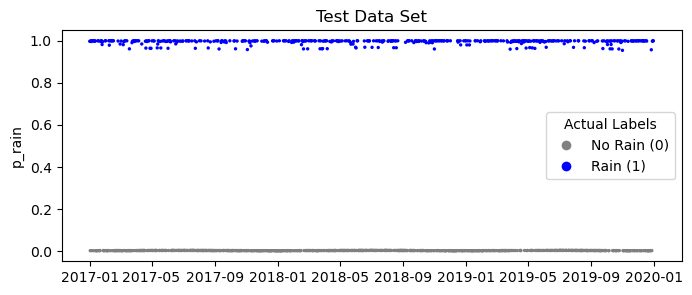

In [185]:
plt.figure(figsize=(8,3))

cmap = mcolors.ListedColormap(["grey", "blue"])  # Choose colors for 0 and 1
scatter = plt.scatter(results_df.DATE, results_df.PRCP_PROB, s=2, c=results_df.PRCP_TF, cmap=cmap)

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="grey", markersize=8, label="No Rain (0)"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="blue", markersize=8, label="Rain (1)")
]

plt.title("Test Data Set")
plt.legend(title="Actual Labels", handles=handles)
plt.ylabel('p_rain')
plt.show()

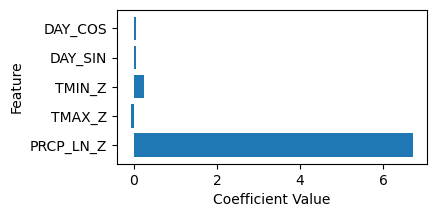

In [186]:
coefficients = ln_model.coef_[0]
intercept = ln_model.intercept_
feature_names = X_test.columns 

plt.figure(figsize=(4,2))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Compare Approaches for 'Chance of Rain' on a Given Day

In [187]:
def chance_of_precip_univariate(df_city, city, month, day):
    """
    Estimate the probability of precipitation for a given city and date.

    Logic:
    Simple framing as the likelihood of precip given past observations of precip on a given day.
    I used only the presence or absense of precip (discrete) to define the likelihood function, 
    but in reality, a joint distribution of continuous precip and temp values may provide better results.

    Parameters:
    city (str): City name (e.g., 'bos', 'jnu', 'mia')
    month (int): Month of the year (1-12)
    day (int): Day of the month (1-31)

    Returns:
    float: Precipitation likelihood (0 to 1)
    """

    df_a_day = df_city[(df_city.NAME == city) & (df_city.MONTH == month) & (df_city.DAY == day)]

    n_obs = len(df_a_day)
    if n_obs == 0:  
        return np.nan
    
    n_rain_obs = df_a_day['PRCP_TF'].sum()
    
    # Binominal coefficient is because order (Rain, Dry, Dry) doesn't matter for the likelihood func.
    binomial_coeff = math.factorial(n_obs) / (math.factorial(n_rain_obs) * math.factorial(n_obs-n_rain_obs))

    p_vec = np.linspace(0.01, 1, 100)
    f_p = binomial_coeff * (p_vec ** n_rain_obs) * ((1 - p_vec) ** (n_obs - n_rain_obs))

    p_rain = p_vec[np.argmax(f_p)]

    return float(p_rain)

In [188]:
def chance_of_precip_multivariate(df_city, city, month, day, intercept, coefficients):
    """df: pandas dataframe of weather data with transformations
       city: str ('bos', 'jnu', 'mia')
       month: int, 
       day: int
       intercept from logistic regression: float
       coefficients from logistic regression: float"""

    df_a_day = df_city[(df_city.NAME == city) & (df_city.MONTH == month) & (df_city.DAY == day)]

    n_obs = len(df_a_day)
    if n_obs == 0:  
        return np.nan

    c = coefficients
    y = intercept + c[0] * df_a_day['PRCP_LN_Z'] + c[1] * df_a_day['TMAX_Z'] + c[2] * df_a_day['TMIN_Z'] + c[3] * df_a_day['DAY_SIN']+ c[4] * df_a_day['DAY_COS']
    p_rain = 1 / (1 + np.exp(-y)) 

    return round(float(p_rain.mean()),4)

In [189]:
p_rain_uni = chance_of_precip_univariate(df_city, 'bos', 12, 5)
p_rain_multi = chance_of_precip_multivariate(df_city, 'bos', 12, 5, intercept, coefficients)
print(p_rain_uni, p_rain_multi)

0.4 0.3965


In [190]:
uni_results = []
multi_results = []

for month in np.arange(1, 13):
    for day in np.arange(1, 32):
        uni_results.append(chance_of_precip_univariate(df_city, 'bos', month, day)) 
        multi_results.append(chance_of_precip_multivariate(df_city, 'bos', month, day, intercept, coefficients))

uni_results = [x for x in uni_results if x is not None and not (isinstance(x, float) and math.isnan(x))]
multi_results = [x for x in multi_results if x is not None and not (isinstance(x, float) and math.isnan(x))]

print(len(uni_results), len(multi_results))


366 366


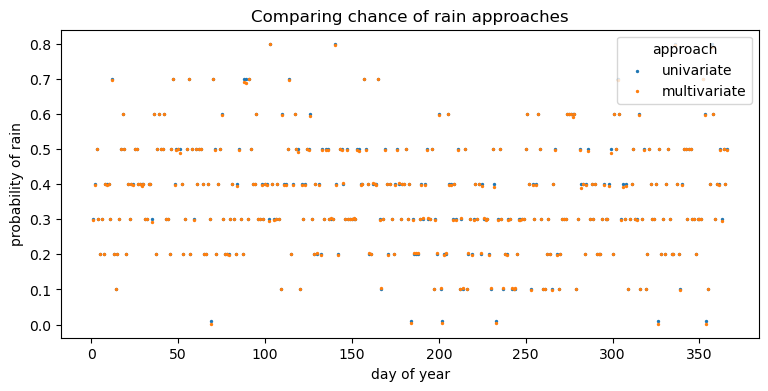

In [191]:
plt.figure(figsize=(9,4))
plt.scatter(range(1,367), uni_results, s=2, label='univariate')
plt.scatter(range(1,367), multi_results, s=2, label='multivariate')
plt.xlabel('day of year')
plt.ylabel('probability of rain')
plt.title("Comparing chance of rain approaches")
plt.legend(title='approach', loc=1)
plt.show()

In [ ]:
# Definitely go with the simple approach on this one.